In [9]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('project_data_preprocessed.csv')

# Constants
CRITICAL_Z = 1.5
NUM_SAMPLES = 5000
CONFIDENCE = 0.95
K = 1

## Matching with propensity score

In [10]:
# Define the covariates (pre-treatment variables) for matching
covariates = ['hour', 'season', 'Beat', 'District', 'Community Area', 'Primary Type']

# Convert categorical variables to dummies (One-Hot Encoding)
data_dummies = pd.get_dummies(data[covariates], drop_first=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_dummies)

T = data['T'].astype(int)
Y = data['Arrest'].astype(int)

# Propensity score estimation using Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_scaled, T)

# Get the predicted propensity scores
data['ps'] = log_model.predict_proba(X_scaled)[:, 1]

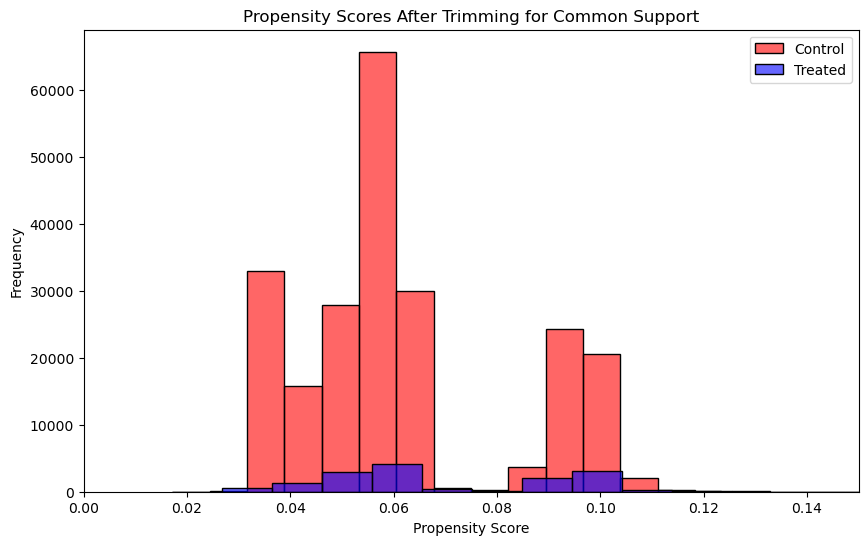

In [19]:
# Common support: Trim control units without overlap
treated_min = data[data['T'] == 1]['ps'].min()
treated_max = data[data['T'] == 1]['ps'].max()

# Remove control units outside this range
common_support = data[(data['ps'] >= treated_min) & (data['ps'] <= treated_max)]

# Create separate treated and control datasets
control = common_support[common_support['T'] == 0]
treated = common_support[common_support['T'] == 1]

# Visualize propensity scores after trimming for common support
plt.figure(figsize=(10,6))
sns.histplot(control['ps'], bins=50, color='red', alpha=0.6, label='Control')
sns.histplot(treated['ps'], bins=50, color='blue', alpha=0.6, label='Treated')
plt.title('Propensity Scores After Trimming for Common Support')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
ax = plt.gca()
ax.set_xlim([0, 0.15])
plt.legend()
plt.show()


In [12]:
def calculate_ate(control, treated, k=K):
    """
    ATE estimation using Nearest Neighbors matching.
    Args:
        control (pd.DataFrame): Control group data
        treated (pd.DataFrame): Treated group data
        k (int): Number of nearest neighbors to consider
    Returns:
        ATE (float): Estimated Average Treatment Effect
    """
    
    # Matching using nearest neighbors (1-to-1 matching)
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(control[['ps']])
    distances, indices = nn.kneighbors(treated[['ps']])

    # Find matched control samples
    matched_controls = control.iloc[indices.flatten()]

    # Combine treated and matched control samples into one dataset
    matched_data = pd.concat([treated, matched_controls])

    # Estimate ATE
    ATE = matched_data.groupby('T')['Arrest'].mean().diff().iloc[-1]
    return ATE

def bootstrap_ate(df, n_bootstrap=NUM_SAMPLES, confidence=CONFIDENCE):
    """
    Bootstrap estimation of Average Treatment Effect (ATE) with confidence intervals.
    Args:
        df (pd.DataFrame): Input data
        n_bootstrap (int): Number of bootstrap samples
        alpha (float): p-value for confidence interval
    Returns:
        ate_mean (float): Mean ATE estimate
        ate_ci_lower (float): Lower bound of confidence interval
        ate_ci_upper (float): Upper bound of confidence interval
    """

    ate_estimates = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        df_resample = resample(df)
        control = df_resample[df_resample['T'] == 0]
        treated = df_resample[df_resample['T'] == 1]
        # Calculate ATE on the resampled data
        ate_estimate = calculate_ate(control, treated)
        ate_estimates.append(ate_estimate)
    
    # Calculate the CI percentiles
    lower_bound = np.percentile(ate_estimates, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(ate_estimates, (1 + confidence) / 2 * 100)
    
    return np.mean(ate_estimates), lower_bound, upper_bound


ate_mean, ate_ci_lower, ate_ci_upper = bootstrap_ate(common_support, NUM_SAMPLES, CONFIDENCE)
print(f'ATE: {ate_mean:.4f}')
print(f'{CONFIDENCE * 100}% Confidence Interval: [{ate_ci_lower:.4f}, {ate_ci_upper:.4f}]')

ATE: 0.0107
95.0% Confidence Interval: [0.0024, 0.0189]


## Different effect of T in winter vs other seasons

In [13]:
# Group by Season and Treatment to calculate arrest rates
arrest_rates = data.groupby(['season', 'T'])['Arrest'].mean().unstack()
arrest_rates

T,False,True
season,,
Fall,0.100637,0.116181
Spring,0.133581,0.148162
Summer,0.115421,0.122386
Winter,0.119204,0.110707


In [14]:
df = data[['Arrest', 'T', 'season']]

# One-Hot Encoding for 'season'
df = pd.get_dummies(df, columns=['season'], drop_first=False)

# Interaction terms between 'T' and seasons
df['T:season_Winter'] = df['T'] * df['season_Winter']
df['T:season_Fall'] = df['T'] * df['season_Fall']
df['T:season_Spring'] = df['T'] * df['season_Spring']
df['T:season_Summer'] = df['T'] * df['season_Summer']

# Features (X) and target variable (y)
X = df[['T:season_Winter', 'T:season_Spring', 'T:season_Summer', 'T:season_Fall']]
y = df['Arrest']

def calculate_coefficients(X, y):
    """
    Calculate coefficients for the logistic regression model.
    Args:
        X (pd.DataFrame): Input features
        y (pd.Series): Target variable
    Returns:
        coefficients (np.array): Array of coefficients
    """

    # Logistic Regression model (balanced classes)
    logit_model = LogisticRegression(class_weight='balanced')
    logit_model.fit(X, y)

    # Get the coefficients
    coefficients = logit_model.coef_[0]
    intercept = logit_model.intercept_

    return np.hstack([intercept, coefficients])

def bootstrap_coefficients(X, y, n_bootstrap=NUM_SAMPLES, confidence=CONFIDENCE):
    """
    Bootstrap estimation of coefficients for the logistic regression model.
    Args:
        X (pd.DataFrame): Input features
        y (pd.Series): Target variable
        n_bootstrap (int): Number of bootstrap samples
    Returns:
        bootstrap_coefs (np.array): Array of bootstrap coefficients
    """
    bootstrap_coefs = []
    for _ in range(n_bootstrap):
        # Resample the training data with replacement
        X_resample, y_resample = resample(X, y)

        # Calculate coefficients on the resampled data
        coefs = calculate_coefficients(X_resample, y_resample)
        bootstrap_coefs.append(coefs)

    ci_lower = np.percentile(bootstrap_coefs, ((1 - confidence) / 2) * 100, axis=0)
    ci_upper = np.percentile(bootstrap_coefs, ((1 + confidence) / 2) * 100, axis=0)
    average_coefs = np.mean(bootstrap_coefs, axis=0)
    return average_coefs, ci_lower, ci_upper
    

average_coefs, ci_lower, ci_upper = bootstrap_coefficients(X, y, NUM_SAMPLES, CONFIDENCE)
coef_names = ['Intercept', 'T:Winter', 'T:Spring', 'T:Summer', 'T:Fall']
for name, coef, lower, upper in zip(coef_names, average_coefs, ci_lower, ci_upper):
    print(f'{name}:\nAverage value: {coef:.4f}\n95% Confidence Interval: [{lower:.4f}, {upper:.4f}]\n')

Intercept:
Average value: -0.0075
95% Confidence Interval: [-0.0106, -0.0044]

T:Winter:
Average value: -0.0434
95% Confidence Interval: [-0.1904, 0.0423]

T:Spring:
Average value: 0.2832
95% Confidence Interval: [0.2036, 0.3607]

T:Summer:
Average value: 0.0479
95% Confidence Interval: [-0.0386, 0.1541]

T:Fall:
Average value: -0.0033
95% Confidence Interval: [-0.0936, 0.0896]



In [15]:
seasons_dfs = [(season_name, data[data['season'] == season_name]) for season_name in ['Winter', 'Spring', 'Summer', 'Fall']]

for season in seasons_dfs:
    season_name, df = season
    ate_mean, ate_ci_lower, ate_ci_upper = bootstrap_ate(df, NUM_SAMPLES, CONFIDENCE)

    print(f'ATE of {season_name}: {ate_mean:.4f}')
    print(f'{CONFIDENCE * 100}% Confidence Interval: [{ate_ci_lower:.4f}, {ate_ci_upper:.4f}]\n')

ATE of Winter: -0.0012
95.0% Confidence Interval: [-0.0236, 0.0205]

ATE of Spring: 0.0112
95.0% Confidence Interval: [-0.0035, 0.0258]

ATE of Summer: 0.0079
95.0% Confidence Interval: [-0.0085, 0.0239]

ATE of Fall: 0.0166
95.0% Confidence Interval: [0.0017, 0.0311]



## Effect of T in different violations type

In [16]:
# Todo: Calculate with NUM_SAMPLES
crimes_dfs = [(crime_type_name, data[data['Primary Type'] == crime_type_name]) for crime_type_name in data['Primary Type'].unique()]

for crime_type in crimes_dfs:
    crime_type_name, df = crime_type
    if len(df) < 200:
        continue
    ate_mean, ate_ci_lower, ate_ci_upper = bootstrap_ate(df, NUM_SAMPLES, CONFIDENCE)

    if abs(ate_mean) > 0.03:
        print(f'ATE of {crime_type_name}: {ate_mean:.4f}')
        print(f'{CONFIDENCE * 100}% Confidence Interval: [{ate_ci_lower:.4f}, {ate_ci_upper:.4f}]\n')

ATE of WEAPONS VIOLATION: 0.0680
95.0% Confidence Interval: [0.0071, 0.1284]

ATE of CRIMINAL SEXUAL ASSAULT: 0.0550
95.0% Confidence Interval: [-0.0096, 0.1188]

ATE of HOMICIDE: 0.0782
95.0% Confidence Interval: [-0.1250, 0.2766]

ATE of STALKING: 0.0342
95.0% Confidence Interval: [-0.0698, 0.1429]

ATE of ARSON: 0.0699
95.0% Confidence Interval: [-0.1071, 0.2400]

ATE of INTERFERENCE WITH PUBLIC OFFICER: -0.0822
95.0% Confidence Interval: [-0.2727, 0.1111]

ATE of PROSTITUTION: 0.0306
95.0% Confidence Interval: [0.0000, 0.1364]

